In [19]:
# We'll need numpy for some mathematical operations
import numpy as np
import math

# matplotlib for displaying the output
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

# and IPython.display for audio output
import IPython.display as ipd

# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display

import timeit

import glob
import os

from nearpy import Engine
from nearpy.hashes import RandomBinaryProjections

# Import local modules
from helpers import *

In [2]:
# Load all sample files
filedir = "../testSounds"  #"/Volumes/External Storage/Thesis/Corpus/eng-balm-emmanuel/flac"  
segment_length = 0.2  # length of segments in seconds

sounds, samplerates = load_sounds(filedir)
spectrograms, mfccs, rmss, centroids, max_num_segs = analyze_sounds(sounds, samplerates, segment_length)

num_files = len(sounds)

directory = '/Users/aaronkarp/Documents/Thesis/Code/savedData/'
to_save = [['samplerates', samplerates], ['spectrograms', spectrograms], ['mfccs', mfccs], ['rmss', rmss], ['centroids', centroids]]
save_data(to_save, directory)

Loading...
7%     13%     20%     27%     33%     40%     47%     53%     60%     67%     73%     80%     87%     93%     Finished Loading
Analyzing...
Finished Analyzing

Average number of segments:  7.133333333333334
saved samplerates
saved spectrograms
saved mfccs
saved rmss
saved centroids


In [3]:
## Organize features into lists of segments
# feature1 = [segment1 segment2 segment3]
# segment1 = nxm np.matrix 

spectrograms_by_seg = []
spectrograms_by_seg_flat = []
for i in range(max_num_segs):
    seg = np.empty((num_files,128,spectrograms[0][0].shape[1]))
    seg[:] = np.nan
    seg_flat = np.empty((num_files,128*spectrograms[0][0].shape[1]))
    seg_flat[:] = np.nan
    for j in range(num_files):
        if i < len(spectrograms[j]):
            seg[j] = spectrograms[j][i]
            seg_flat[j] = vectorize(spectrograms[j][i])
    spectrograms_by_seg.append(seg)
    spectrograms_by_seg_flat.append(seg_flat)

In [27]:
# Build LSHs for spectrograms_by_seg

engines = []
num_bits = 40 # How many bits to use for hashing
for seg in spectrograms_by_seg_flat:
    engines.append(build_lsh(seg, num_bits))

[0, 0, 0, 7, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0]
[None, None, None, 5.551115123125783e-16, None, None, None, 0.03949196596527593, None, None, None, None, None, None, None]

Original query: 3


Best guess: 3


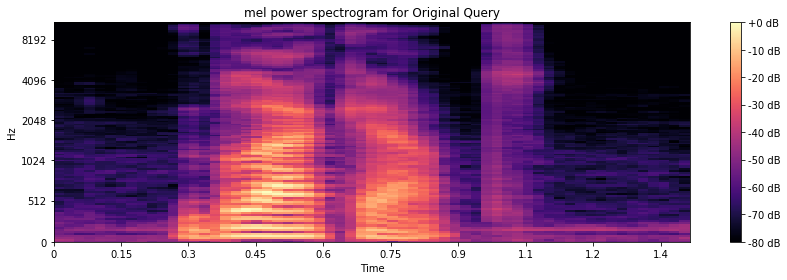

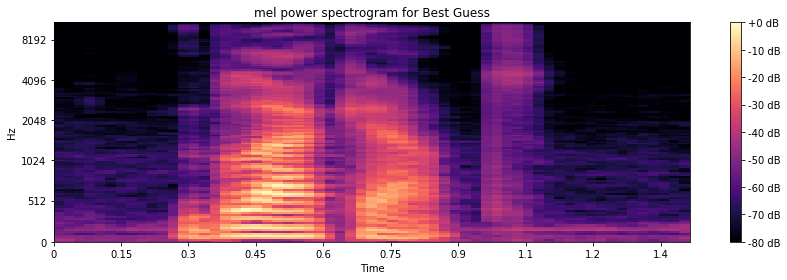

In [38]:
# Query

query = 3  # File index

scores = [0]*num_files
distances = [0]*num_files
cur_seg = 0
for engine in engines:
    # Get nearest neighbours
    N = engine.neighbours(spectrograms_by_seg_flat[cur_seg][query])
    for entry in N:
        index = parse_index(entry[1])
        if not math.isnan(entry[2]):
            scores[index] += 1
            distances[index] += entry[2]
    cur_seg += 1

for i in range(len(scores)):
    if scores[i] == 0:
        distances[i] = None

best_guess = distances.index(min(x for x in distances if x is not None))
        
print(scores)
print(distances)
print()
print("Original query: " + str(query))
ipd.display(ipd.Audio(sounds[query], rate = samplerates[query])) # load search file
print("Best guess: " + str(best_guess))
ipd.display(ipd.Audio(sounds[best_guess], rate = samplerates[best_guess])) # load matched file

plt.figure(figsize=(12,4))
S = librosa.feature.melspectrogram(sounds[query], sr=samplerates[query], n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(log_S, sr=samplerates[query], x_axis='time', y_axis='mel')
plt.title('mel power spectrogram for Original Query')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

plt.figure(figsize=(12,4))
S = librosa.feature.melspectrogram(sounds[best_guess], sr=samplerates[best_guess], n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(log_S, sr=samplerates[best_guess], x_axis='time', y_axis='mel')
plt.title('mel power spectrogram for Best Guess')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()
